# Stellargraph Ensembles

Examples of using `stellargraph` graph neural network models, e.g., `GraphSAGE` and `GCN`, in an ensemble to produce quantifiable predictions.

We demonstrate enseble training and prediction for node attribute inference problems using the Cora and Pubmed-Diabetes datasets.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN

from stellargraph import Ensemble

from keras import layers, optimizers, losses, metrics, Model, models
from sklearn import preprocessing, feature_extraction, model_selection

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [2]:
def plot_history(history):
    plt.figure(figsize=(12, 10))
    
    for h in history:    
        plot_index = 0
        metrics = sorted(h.history.keys())
        
        for i in range(0,len(metrics),2):
            # summarize history for metric m
            plt.subplot(len(metrics)//2, 1, plot_index+1)
         
            c_train = 'b'
            c_test = 'g'

            if metrics[i][0:3] == 'val':
                plt.plot(h.history[metrics[i+1]], c=c_train)
                plt.plot(h.history[metrics[i]], c=c_test)
            else:
                plt.plot(h.history[metrics[i]], c=c_train)
                plt.plot(h.history[metrics[i+1]], c=c_test)
            if plot_index <= 1 :
                if metrics[i][0:3] == 'val':
                    plt.title(metrics[i+1])
                else:
                    plt.title(metrics[i])
                plt.ylabel(metrics[i])
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper right')
            plot_index = plot_index + 1

### Loading the network data

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

**Downloading the PubMed-Diabetes dataset:**

The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/Pubmed-Diabetes.tgz

The following is the description of the dataset:

>The Pubmed Diabetes dataset consists of 19717 scientific publications from PubMed database pertaining to diabetes classified into one of three classes. The citation network consists of 44338 links. Each publication in the dataset is described by a TF/IDF weighted word vector from a dictionary which consists of 500 unique words.

Download and unzip the Pubmed-Diabetes.tgz file to a location on your computer.

Set the data_dir variable to point to the location of the processed dataset.

In [3]:
use_cora = True  # Select the dataset; if False, then Pubmed-Diabetes dataset is used.
if use_cora:
    data_dir = os.path.expanduser("~/data/cora")
else:
    data_dir = os.path.expanduser("~/data/pubmed/Pubmed-Diabetes/data")

In [4]:
def load_cora(data_dir, largest_cc=False):
    g_nx = nx.read_edgelist(path=os.path.expanduser(os.path.join(data_dir, "cora.cites")))

    # load the node attribute data
    cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
    node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
    values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
    nx.set_node_attributes(g_nx, values, 'subject')

    if largest_cc:
        # Select the largest connected component. For clarity we ignore isolated
        # nodes and subgraphs; having these in the data does not prevent the
        # algorithm from running and producing valid results.
        g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
        g_nx = max(g_nx_ccs, key=len)
        print("Largest subgraph statistics: {} nodes, {} edges".format(
            g_nx.number_of_nodes(), g_nx.number_of_edges()))
    
    feature_names = ["w_{}".format(ii) for ii in range(1433)]
    column_names =  feature_names + ["subject"]
    node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)
    
    node_data.index = node_data.index.map(str)
    node_data = node_data[node_data.index.isin(list(g_nx.nodes()))]

    return g_nx, node_data, feature_names

In [5]:
def load_pubmed(data_dir):
    edgelist = pd.read_table(os.path.join(data_dir, 'Pubmed-Diabetes.DIRECTED.cites.tab'), 
                             skiprows=2, 
                             header=None )
    edgelist.drop(columns=[0,2], inplace=True)
    edgelist.columns = ['source', 'target']
    # delete unneccessary prefix 
    edgelist['source'] = edgelist['source'].map(lambda x: x.lstrip('paper:')) 
    edgelist['target'] = edgelist['target'].map(lambda x: x.lstrip('paper:'))
    edgelist["label"] = "cites"  # set the edge type
    
    # Load the graph from the edgelist
    g_nx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

    # Load the features and subject for each node in the graph
    nodes_as_dict = []
    with open(os.path.join(os.path.expanduser(data_dir), 
                           "Pubmed-Diabetes.NODE.paper.tab")) as fp:
        for line in itertools.islice(fp, 2, None):
            line_res = line.split("\t")
            pid = line_res[0]
            feat_name = ['pid'] + [l.split("=")[0] for l in line_res[1:]][:-1] # delete summary
            feat_value = [l.split("=")[1] for l in line_res[1:]][:-1] # delete summary
            feat_value = [pid] + [ float(x) for x in feat_value ] # change to numeric from str
            row = dict(zip(feat_name, feat_value))
            nodes_as_dict.append(row)

    # Create a Pandas dataframe holding the node data        
    node_data = pd.DataFrame(nodes_as_dict)
    node_data.fillna(0, inplace=True)
    node_data['label'] = node_data['label'].astype(int)
    node_data['label'] = node_data['label'].astype(str)
    
    node_data.index = node_data['pid']
    node_data.drop(columns=['pid'], inplace=True)
    node_data.head()
    
    feature_names = node_data.columns

    return g_nx, node_data, feature_names

In [6]:
if use_cora:
    Gnx, node_data, feature_names = load_cora(data_dir)
else:
    Gnx, node_data, feature_names = load_pubmed(data_dir)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [7]:
if use_cora:
    print(set(node_data["subject"]))
else:
    print(set(node_data["label"]))

{'Genetic_Algorithms', 'Rule_Learning', 'Neural_Networks', 'Case_Based', 'Reinforcement_Learning', 'Probabilistic_Methods', 'Theory'}


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [8]:
node_label = "label"
if use_cora:
    node_label = "subject"

train_data, test_data = model_selection.train_test_split(node_data, 
                                                         train_size=0.2, #140
                                                         test_size=None, 
                                                         stratify=node_data[node_label], 
                                                         random_state=42)
val_data, test_data = model_selection.train_test_split(test_data, 
                                                       train_size=0.2, #500, 
                                                       test_size=None, 
                                                       stratify=test_data[node_label],
                                                       random_state=100)

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [9]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[[node_label]].to_dict('records'))
val_targets = target_encoding.transform(val_data[[node_label]].to_dict('records'))
test_targets = target_encoding.transform(test_data[[node_label]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [10]:
node_features = node_data[feature_names]

### Specify global parameters

Here we specify some parameters that control the type of model we are going to use. For example, we specify the base model type, e.g., GCN, GraphSAGE, etc, and the number of estimators in the ensemble.

In [11]:
model_type = 'graphsage'    # Can be either gcn or graphsage
use_bagging=True     # If True, each model in the ensemble is trained on a bootstrapped sample
                      # of the given training data; otherwise, the same training data are used
                      # for training each model. 

if model_type == "graphsage":
    # For GraphSAGE model
    batch_size = 50; 
    num_samples = [10, 10]
    n_estimators = 5     # The number of estimators in the ensemble
    n_predictions = 5   # The number of predictions per estimator per query point
    epochs = 15          # The number of training epochs
elif model_type == "gcn":
    # For GCN model
    n_estimators = 5     # The number of estimators in the ensemble
    n_predictions = 10   # The number of predictions per estimator per query point
    epochs = 100         # The number of training epochs

## Creating the base graph machine learning model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [12]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [13]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  default: [2708]
        Attributes: {'subject'}
    Edge types: default-default->default

 Edge types:
    default-default->default: [5278]



To feed data from the graph to the Keras model we need a mapper. The mappers are specialized to the model and the learning task. 

For training we map only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [14]:
if model_type == 'graphsage':
    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
    train_gen = generator.flow(train_data.index, train_targets, shuffle=True)
elif model_type == 'gcn':
    generator = FullBatchNodeGenerator(G)
    train_gen = generator.flow(train_data.index, train_targets)

In [15]:
type(train_data.index), type(train_targets)

(pandas.core.indexes.base.Index, numpy.ndarray)

In [16]:
len(train_data.index)

541

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [17]:
if model_type == 'graphsage':
    base_model = GraphSAGE(
        layer_sizes=[16, 16],
        generator=train_gen,
        bias=True,
        dropout=0.5,
    )
    x_inp, x_out = base_model.default_model(flatten_output=True)
    prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
elif model_type == 'gcn':
    base_model = GCN(
        layer_sizes=[32, train_targets.shape[1]],
        generator = generator,
        bias=True,
        dropout=0.5,
        activations=["elu", "softmax"]
    )
    x_inp, x_out = base_model.node_model()
    prediction = x_out

In [18]:
prediction.shape

TensorShape([Dimension(None), Dimension(7)])

### Create a Keras model and then an Ensemble

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [19]:
model = Model(inputs=x_inp, outputs=prediction)

Next, we create the ensemble model such that it consists of `n_estimators`.

We are also going to specify that we want to make `n_predictions` per query point. These predictions will differ because of the application of `dropout` and, in the case of ensembling GraphSAGE models, the sampling of the node neighbourhoods.

In [20]:
model = Ensemble(model, n_estimators=n_estimators, n_predictions=n_predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    weighted_metrics=["acc"],
)

In [21]:
model  # The model is of type stellargraph.utils.ensemble.Ensemble but has the same interface as a Keras model

In [22]:
model.layers()

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [23]:
val_gen = generator.flow(val_data.index, val_targets)
test_gen = generator.flow(test_data.index, test_targets)

In [24]:
if use_bagging:
    history = model.fit_generator(
        generator,
        train_data = train_data.index,
        train_targets = train_targets,
        epochs=epochs,
        validation_data=val_gen,
        verbose=0,
        shuffle=False
    )
else:
    history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        verbose=0,
        shuffle=False
    )

*** Train with Bagging ***
Unique train data 348 and targets 2
Unique train data 349 and targets 2
Unique train data 355 and targets 2
Unique train data 342 and targets 2
Unique train data 339 and targets 2


/Users/eli024/anaconda3/envs/link-prediction/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


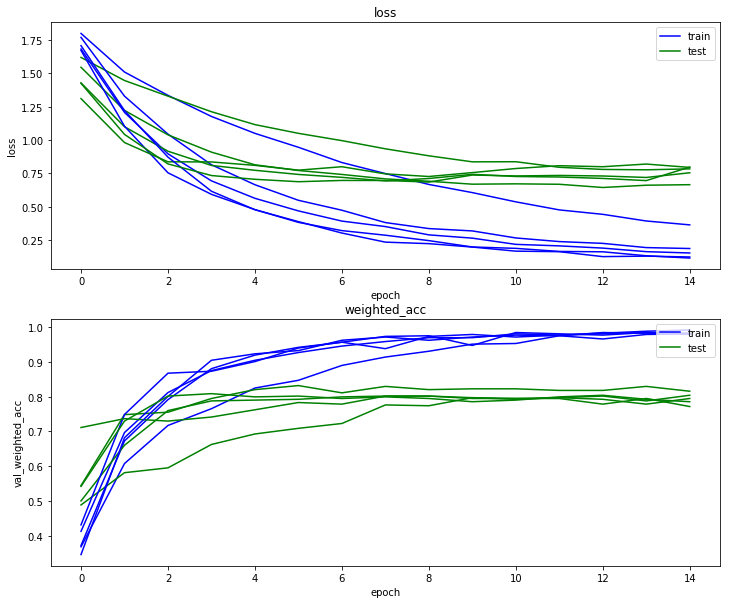

In [25]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [26]:
test_metrics_mean, test_metrics_std = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained models:")
for name, m, s in zip(model.metrics_names(), test_metrics_mean, test_metrics_std):
    print("\t{}: {:0.4f}±{:0.4f}".format(name, m, s))


Train Set Metrics of the trained models:
	loss: 0.7032±0.0337
	weighted_acc: 0.8023±0.0096


### Making predictions with the model

Now let's get the predictions themselves for all nodes using another mapper:

In [27]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [28]:
type(all_predictions), all_predictions.shape

(numpy.ndarray, (5, 5, 2708, 7))

In [29]:
selected_query_point = 99

In [30]:
qp_predictions = all_predictions[:, :, selected_query_point, :]
qp_predictions.shape

(5, 5, 7)

In [31]:
qp_predictions = qp_predictions.reshape(np.product(qp_predictions.shape[0:-1]), qp_predictions.shape[-1])
qp_predictions.shape

(25, 7)

In [32]:
inv_subject_mapper = {k: v for k, v in enumerate(target_encoding.feature_names_)}
inv_subject_mapper

{0: 'subject=Case_Based',
 1: 'subject=Genetic_Algorithms',
 2: 'subject=Neural_Networks',
 3: 'subject=Probabilistic_Methods',
 4: 'subject=Reinforcement_Learning',
 5: 'subject=Rule_Learning',
 6: 'subject=Theory'}

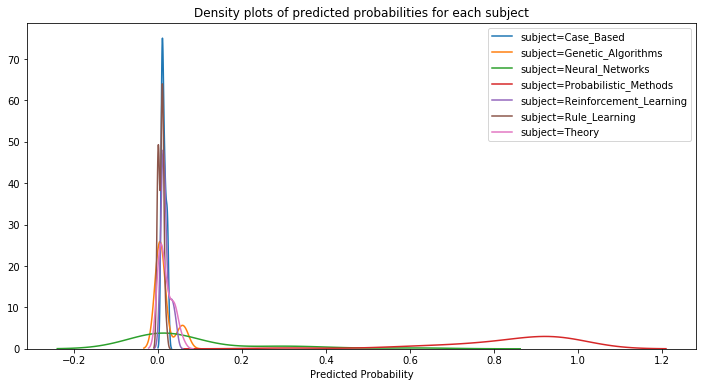

In [33]:
if model_type != 'gcn':
    fig, ax = plt.subplots(figsize=(12,6))
    for i in range(qp_predictions.shape[1]):
        sns.kdeplot(data=qp_predictions[:, i].reshape((-1,)), label=inv_subject_mapper[i])
    plt.xlabel("Predicted Probability")
    plt.title("Density plots of predicted probabilities for each subject")

Another view (boxplot) of the same predictions

Text(0.5,0,'Subject')

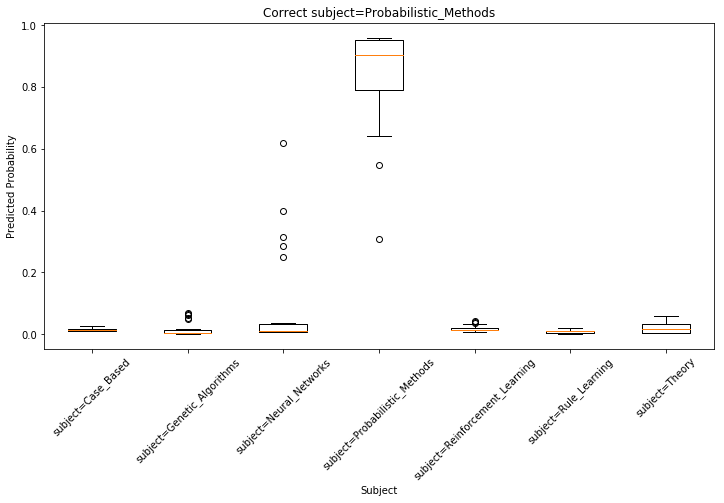

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
ax.boxplot(x=qp_predictions)
ax.set_xticklabels(target_encoding.feature_names_)
ax.tick_params(axis='x', rotation=45)
if model_type == "graphsage":
    y = np.argmax(target_encoding.transform(node_data[[node_label]].to_dict('records')), axis=1)
elif model_type == "gcn":
    y = np.argmax(target_encoding.transform(node_data.reindex(G.nodes())[[node_label]].to_dict('records')), axis=1)
plt.title("Correct "+target_encoding.feature_names_[y[selected_query_point]])
plt.ylabel("Predicted Probability")
plt.xlabel("Subject")

In [35]:
np.sum(np.isfinite(y)), len(y), np.sum(y==0), np.sum(y==1)

(2708, 2708, 298, 418)

## Node embeddings

Evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their subject label.

In [36]:
if model_type == 'graphsage':
    emb = model.predict_generator(all_mapper, output_layer=-4)
elif model_type == 'gcn':
    emb = model.predict_generator(all_mapper, output_layer=3)

In [37]:
emb.shape

(5, 5, 2708, 16)

In [38]:
emb = np.mean(emb, axis=(0,1,))

In [39]:
emb.shape

(2708, 16)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [40]:
X = emb
if model_type == 'graphsage':
    y = np.argmax(target_encoding.transform(node_data[[node_label]].to_dict('records')), 
                  axis=1)
elif model_type == 'gcn':
    y = np.argmax(target_encoding.transform(node_data.reindex(G.nodes())[[node_label]].to_dict('records')), 
                  axis=1)

In [41]:
if X.shape[1] > 2:
    transform = TSNE # PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data.index)
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_data.index)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

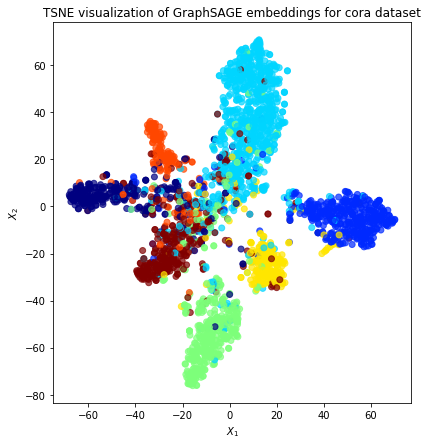

In [42]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()